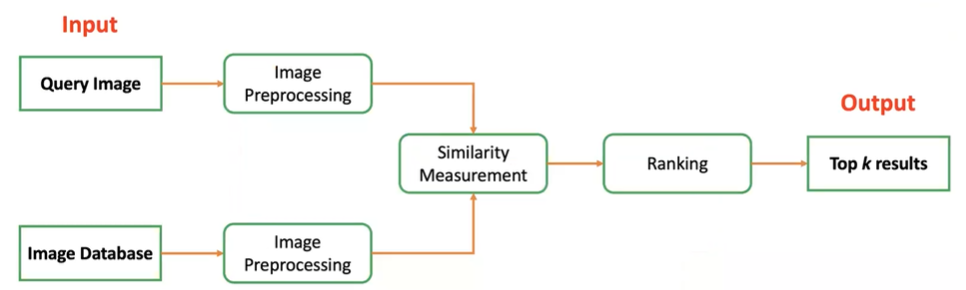

# **READ DATASET**

In [1]:
#get dataset from gg drive
zip_dataset_dir='/content/drive/MyDrive/datasets/Image_Retrieval_Dataset/image_retrieval_dataset.zip'

import zipfile
with zipfile.ZipFile(zip_dataset_dir, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
dataset_dir='/content/images_mr'
image_filenames=os.listdir(dataset_dir)
print('Number of files: ',len(image_filenames))


Number of files:  9908


In [4]:
src_img=[] #empty list for image after reading

for file_name in image_filenames:
    file_path=os.path.join(
        dataset_dir,
        file_name
    )
    image=cv2.imread(file_path)
    image=cv2.cvtColor(
        image,
        cv2.COLOR_BGR2RGB
    )
    src_img.append(image)

# **PREPROCESS IMAGE**
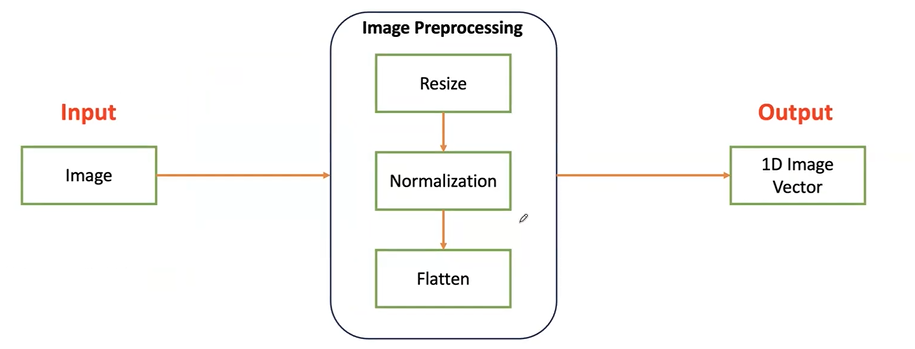

In [21]:
def resize_img(img,target_size):
    resized_img=cv2.resize(
        img,
        target_size
    )
    return resized_img

def norm_img(img):
    mean=np.mean(img,axis=(0,1,2))
    std=np.std(img,axis=(0,1,2))

    normalized_img=(img-mean)/std
    return normalized_img

def flatten_img(img,is_batch): #3D to 1D
    #flatten a batch of image
    if is_batch:
        flattened_img=img.reshape(img.shape[0],-1)
    else:
        flattened_img=img.reshape(-1)
    return flattened_img

def preprocess_batches(src_data):
    resized_imgs=[
        resize_img(img,(64,64)) for img in src_data
    ]
    imgs_arr=np.array(resized_imgs)
    normalized_imgs=(imgs_arr)
    flattened_imgs=flatten_img(normalized_imgs,True)
    return flattened_imgs

def preprocess_query(img):
    resized_img=resize_img(img,(64,64))
    normalized_img=norm_img(resized_img)
    flattened_image=flatten_img(normalized_img,False)
    return flattened_image




# **SIMILARITY METRICS**

In [57]:
def l1_loss(query_vec,src_vecs):
    abs_diff=np.abs(src_vecs-query_vec)
    return np.mean(abs_diff,axis=1)

def l2_loss(query_vec,src_vecs):
    squarred_diff=(src_vecs-query_vec)**2
    return np.mean(squarred_diff,axis=1)

def cos_sim(query_vec,src_vecs):
    query_norm=np.linalg.norm(query_vec)
    src_norm=np.linalg.norm(src_vecs,axis=1)
    norm_query=query_vec/query_norm
    norm_src=src_vecs/src_norm[:,np.newaxis]
    return [np.dot(norm_query,norm_source) for norm_source in norm_src]

def cor_coe(query_vec,src_vecs):
    return np.corrcoef(
        query_vec,src_vecs
    )[:-1,-1]

# **RANKING**

In [65]:
def ranking(preprocess_query_img,preprocess_src_imgs,top_k):
    scores=cos_sim(preprocess_query_img,
                   preprocess_src_imgs)
    ranked_list=np.argsort(scores)[::-1][:top_k] #[::-1]:return list read backward to last to first
    return ranked_list,scores

# **TEST BASELINE**

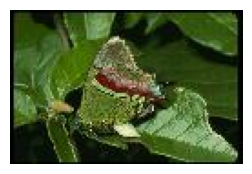

Top 15 results


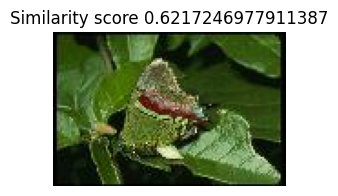

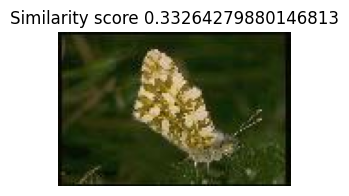

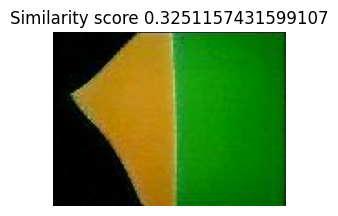

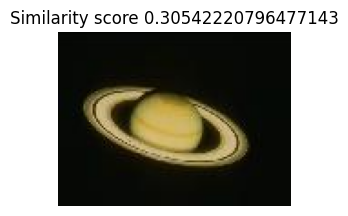

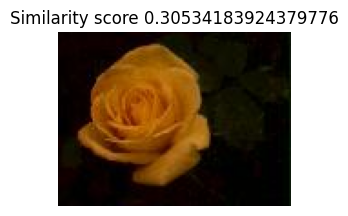

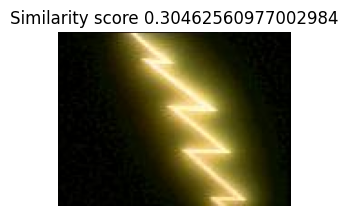

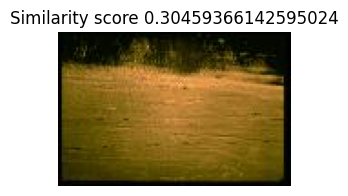

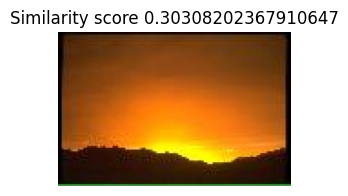

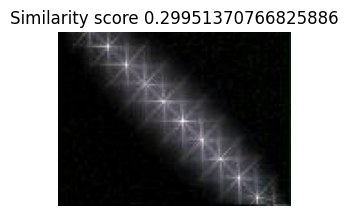

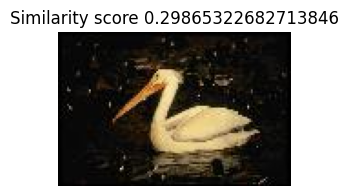

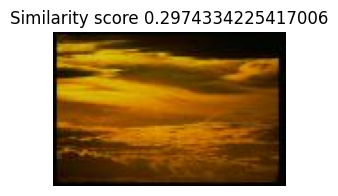

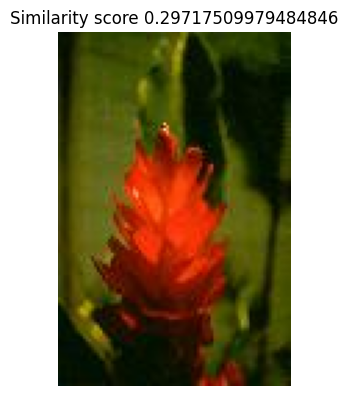

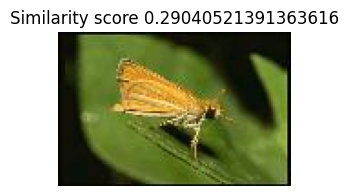

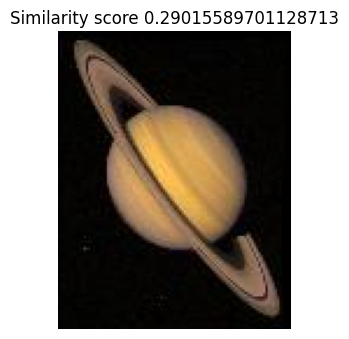

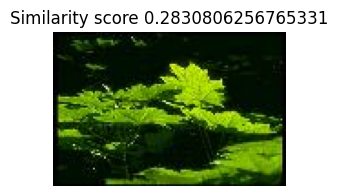

In [70]:
query_img_path='/content/images_mr/1.jpg'

top_k=15

query_img=cv2.imread(query_img_path,1)
query_img=cv2.cvtColor(query_img,cv2.COLOR_BGR2RGB)
preprocess_query_img=preprocess_query(query_img)
preprocess_src_imgs=preprocess_batches(src_img)
ranked_list,scores=ranking(preprocess_query_img,preprocess_src_imgs,top_k)

plt.figure(figsize=(3,5))
plt.imshow(query_img)
plt.axis('off')
plt.show()
print(f'Top {top_k} results')
for idx in range(len(ranked_list)):
    src_img_idx=ranked_list[idx]
    sim_score=scores[src_img_idx]
    plt.figure(figsize=(3,5))
    plt.imshow(src_img[src_img_idx])
    plt.title(f'Similarity score {sim_score}')
    plt.axis('off')
    plt.show()